<a href="https://colab.research.google.com/github/NevesJulio/Exercicios_DL/blob/main/06_generalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Subset

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Configuração para gráficos
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Configurar dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Dispositivo utilizado: {device}')

Dispositivo utilizado: cuda


## 4. Análise de Overfitting com MNIST

### 4.1 Efeito do Tamanho do Dataset de Treinamento

Vamos investigar como o tamanho do conjunto de treinamento afeta o overfitting usando o dataset MNIST. Iremos treinar redes neurais com diferentes quantidades de dados de treinamento e observar como isso impacta a generalização.

#### Hipóteses:
- **Poucos dados**: Alto overfitting (grande gap entre treino e validação)
- **Mais dados**: Menor overfitting e melhor generalização
- **Muitos dados**: Convergência para o limite teórico de performance

In [11]:
# Carregar o dataset MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Normalização específica do MNIST
])

# Carregar datasets completos
train_dataset_full = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform
)

train_loader = DataLoader(
    Subset(train_dataset_full, range(400)),
    batch_size=64,
    shuffle=True
)

val_dataset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform
)

val_loader = DataLoader(
    Subset(val_dataset, range(100)),
    batch_size=64,
    shuffle=False
)


### 4.2 Arquitetura da Rede Neural

In [12]:
class MNISTClassifier(nn.Module):
    """Rede neural simples para classificação MNIST."""

    def __init__(self, hidden_size=128):
        super(MNISTClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28 * 28, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Testar a arquitetura
model_test = MNISTClassifier(hidden_size=128)
print(f'Arquitetura do modelo:')
print(model_test)

# Contar parâmetros
total_params = sum(p.numel() for p in model_test.parameters())
trainable_params = sum(p.numel() for p in model_test.parameters() if p.requires_grad)
print(f'\nTotal de parâmetros: {total_params:,}')
print(f'Parâmetros treináveis: {trainable_params:,}')

Arquitetura do modelo:
MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)

Total de parâmetros: 118,282
Parâmetros treináveis: 118,282


### 4.3 Função de Treinamento e Avaliação

In [13]:
def train_mnist_model(train_loader, val_loader, epochs=20, lr=0.001, hidden_size=128):
    """Treina modelo MNIST e retorna histórico de métricas."""

    model = MNISTClassifier(hidden_size=hidden_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Treinamento
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            train_total += target.size(0)
            train_correct += (predicted == target).sum().item()

        # Avaliação no conjunto de validação
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                val_total += target.size(0)
                val_correct += (predicted == target).sum().item()

        # Calcular métricas da época
        train_loss_avg = train_loss / len(train_loader)
        train_acc = 100 * train_correct / train_total
        val_loss_avg = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        train_losses.append(train_loss_avg)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss_avg)
        val_accuracies.append(val_acc)

        if (epoch + 1) % 5 == 0:
            print(f'Época {epoch+1}/{epochs}: '
                  f'Train Loss: {train_loss_avg:.4f}, Train Acc: {train_acc:.2f}% | '
                  f'Val Loss: {val_loss_avg:.4f}, Val Acc: {val_acc:.2f}%')

    return model, {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'val_losses': val_losses,
        'val_accuracies': val_accuracies
    }

### 4.4 Experimento: Variando o Tamanho do Dataset de Treinamento

In [18]:
# Definir diferentes tamanhos de dataset para o experimento
HidenLayer_sizes = [8, 16, 32]
batch_size = 64
epochs = 20

# Inicializar dicionários para armazenar resultados
results_by_size = {}
models_by_size = {}


In [19]:
# Executar experimentos para cada tamanho de dataset
for size in HidenLayer_sizes:
    print(f"Treinando com arquitetura de {size} neurônios...")

    # Treinar modelo
    model, history = train_mnist_model(
        train_loader=train_loader,
        val_loader=val_loader,
        epochs=epochs,
        lr=0.001,
        hidden_size=size
    )

    # Armazenar resultados
    results_by_size[size] = history
    models_by_size[size] = model

    print(f"Concluído para {size} exemplos")

print("Todos os experimentos concluídos!")

Treinando com arquitetura de 8 neurônios...
Época 5/20: Train Loss: 1.8680, Train Acc: 30.75% | Val Loss: 1.9360, Val Acc: 28.00%
Época 10/20: Train Loss: 1.5280, Train Acc: 47.75% | Val Loss: 1.5850, Val Acc: 46.00%
Época 15/20: Train Loss: 1.1177, Train Acc: 63.75% | Val Loss: 1.2850, Val Acc: 56.00%
Época 20/20: Train Loss: 0.8463, Train Acc: 71.00% | Val Loss: 1.1135, Val Acc: 60.00%
Concluído para 8 exemplos
Treinando com arquitetura de 16 neurônios...
Época 5/20: Train Loss: 1.8197, Train Acc: 47.00% | Val Loss: 1.8952, Val Acc: 47.00%
Época 10/20: Train Loss: 1.0601, Train Acc: 77.25% | Val Loss: 1.2777, Val Acc: 66.00%
Época 15/20: Train Loss: 0.5325, Train Acc: 88.75% | Val Loss: 0.8758, Val Acc: 78.00%
Época 20/20: Train Loss: 0.3207, Train Acc: 93.25% | Val Loss: 0.7158, Val Acc: 80.00%
Concluído para 16 exemplos
Treinando com arquitetura de 32 neurônios...
Época 5/20: Train Loss: 1.0283, Train Acc: 78.00% | Val Loss: 1.0751, Val Acc: 69.00%
Época 10/20: Train Loss: 0.3919, 

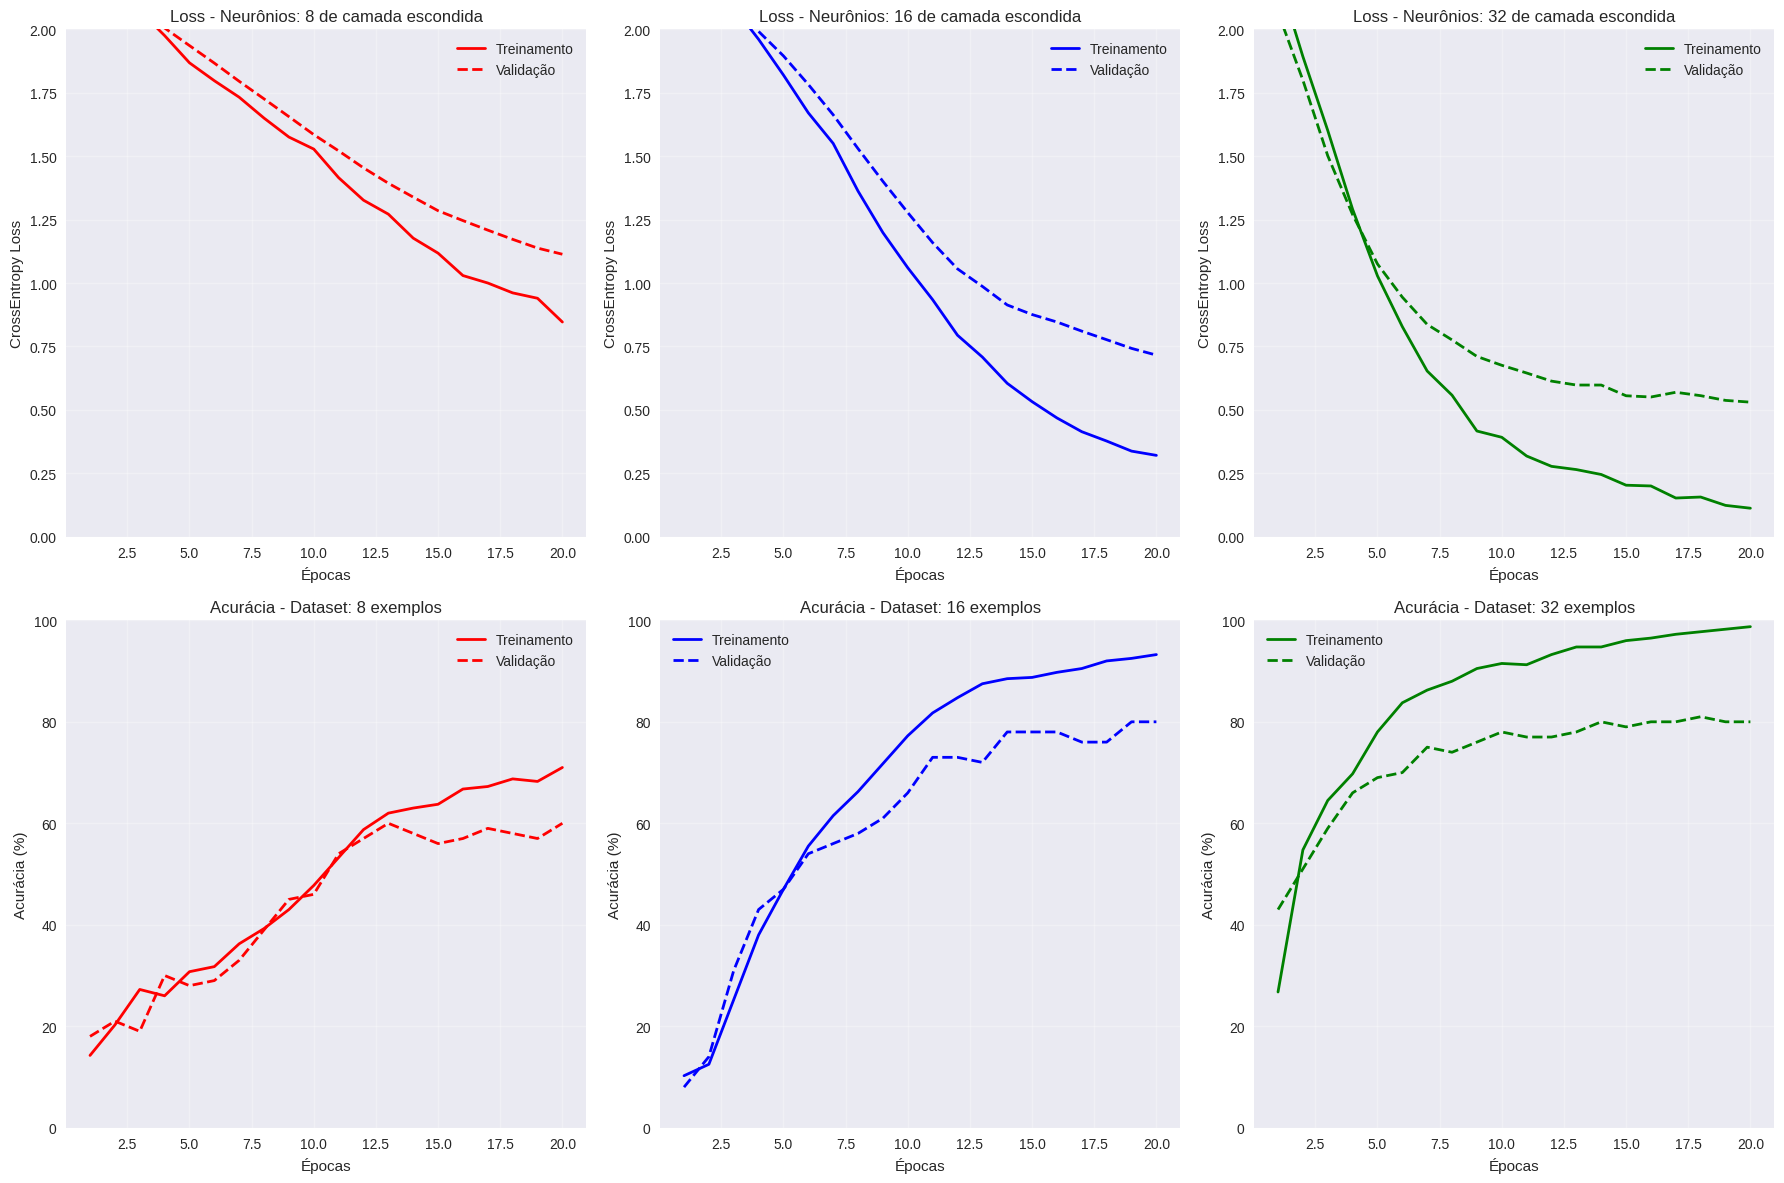

In [22]:
# Visualizar curvas de treinamento
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
colors = ['r', 'b', 'g']

for i, size in enumerate(HidenLayer_sizes):
    history = results_by_size[size]
    color = colors[i]

    # Curvas de loss
    ax_loss = axes[0, i]
    epochs_range = range(1, len(history['train_losses']) + 1)
    ax_loss.plot(epochs_range, history['train_losses'], f'{color}-', linewidth=2, label='Treinamento')
    ax_loss.plot(epochs_range, history['val_losses'], f'{color}--', linewidth=2, label='Validação')
    ax_loss.set_title(f'Loss - Neurônios: {size} de camada escondida')
    ax_loss.set_xlabel('Épocas')
    ax_loss.set_ylabel('CrossEntropy Loss')
    ax_loss.legend()
    ax_loss.grid(True, alpha=0.3)
    ax_loss.set_ylim([0, 2])

    # Curvas de acurácia
    ax_acc = axes[1, i]
    ax_acc.plot(epochs_range, history['train_accuracies'], f'{color}-', linewidth=2, label='Treinamento')
    ax_acc.plot(epochs_range, history['val_accuracies'], f'{color}--', linewidth=2, label='Validação')
    ax_acc.set_title(f'Acurácia - Dataset: {size} exemplos')
    ax_acc.set_xlabel('Épocas')
    ax_acc.set_ylabel('Acurácia (%)')
    ax_acc.legend()
    ax_acc.grid(True, alpha=0.3)
    ax_acc.set_ylim([0, 100])

plt.tight_layout()
plt.show()

### 4.5 Análise dos Resultados

In [ ]:
# Analisar resultados finais
print("=== ANÁLISE DE OVERFITTING POR TAMANHO DO DATASET ===\\n")

analysis_results = []
for size in dataset_sizes:
    history = results_by_size[size]

    # Métricas finais (última época)
    final_train_loss = history['train_losses'][-1]
    final_val_loss = history['val_losses'][-1]
    final_train_acc = history['train_accuracies'][-1]
    final_val_acc = history['val_accuracies'][-1]

    # Gap entre treino e validação (indicador de overfitting)
    loss_gap = final_val_loss - final_train_loss
    acc_gap = final_train_acc - final_val_acc

    analysis_results.append({
        'Dataset Size': size,
        'Train Loss': f'{final_train_loss:.4f}',
        'Val Loss': f'{final_val_loss:.4f}',
        'Loss Gap': f'{loss_gap:.4f}',
        'Train Acc': f'{final_train_acc:.2f}%',
        'Val Acc': f'{final_val_acc:.2f}%',
        'Acc Gap': f'{acc_gap:.2f}%'
    })

    print(f"📈 Dataset com {size} exemplos:")
    print(f"   Loss: Treino {final_train_loss:.4f} | Validação {final_val_loss:.4f} | Gap {loss_gap:.4f}")
    print(f"   Acc:  Treino {final_train_acc:.2f}% | Validação {final_val_acc:.2f}% | Gap {acc_gap:.2f}%")
    print()

# Criar tabela resumo
df_analysis = pd.DataFrame(analysis_results)
print("📋 TABELA RESUMO:")
print(df_analysis.to_string(index=False))

### 4.6 Visualizações Comparativas

In [ ]:
# Gráfico de barras comparativo do gap de overfitting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Extrair dados para os gráficos
dataset_sizes_str = [str(size) for size in dataset_sizes]
loss_gaps = []
acc_gaps = []

for size in dataset_sizes:
    history = results_by_size[size]
    loss_gap = history['val_losses'][-1] - history['train_losses'][-1]
    acc_gap = history['train_accuracies'][-1] - history['val_accuracies'][-1]
    loss_gaps.append(loss_gap)
    acc_gaps.append(acc_gap)

# Gráfico de gap de loss
bars1 = ax1.bar(dataset_sizes_str, loss_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax1.set_title('Gap de Loss (Val - Train)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Tamanho do Dataset de Treinamento')
ax1.set_ylabel('Gap de Loss')
ax1.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars1, loss_gaps):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.3f}', ha='center', va='bottom', fontweight='bold')

# Gráfico de gap de acurácia
bars2 = ax2.bar(dataset_sizes_str, acc_gaps, color=['lightcoral', 'lightblue', 'lightgreen'],
                edgecolor='black', linewidth=1.5, alpha=0.8)
ax2.set_title('Gap de Acurácia (Train - Val)\n(Maior = Mais Overfitting)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Tamanho do Dataset de Treinamento')
ax2.set_ylabel('Gap de Acurácia (%)')
ax2.grid(True, axis='y', alpha=0.3)

# Adicionar valores nas barras
for bar, value in zip(bars2, acc_gaps):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.2,
             f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

### 4.7 Conclusões do Experimento

#### Implicações Práticas:

- **Mais dados = Melhor generalização**: O aumento do tamanho do dataset reduziu consistentemente o overfitting
- **Bias-Variance Tradeoff**: Datasets maiores reduzem a variância do modelo
- **Capacidade do Modelo**: A mesma arquitetura se beneficia diferentemente dependendo da quantidade de dados

#### Insights Teóricos:

- O **ruído nos dados** tem menos impacto quando há mais exemplos diversos
- A **complexidade do modelo** deve ser ajustada de acordo com a quantidade de dados disponíveis

## Exercício

Usando o dataset MNIST já carregado (500 exemplos), compare três arquiteturas diferentes e identifique qual apresenta menor overfitting. Analise os gaps de loss e acurácia entre treinamento e validação.